Enter the stock symbol: infy


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\aakas\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


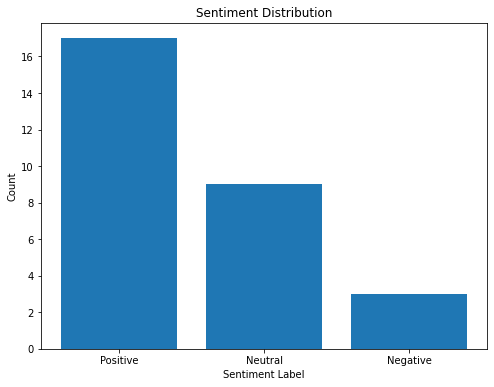

85.0
Positive


In [23]:
import requests
import csv
import pandas as pd
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt

# Stock symbol
stock_symbol = input("Enter the stock symbol: ")
stock_symbol = stock_symbol.upper()
# NewsAPI settings
news_api_key = '0594c37f48004f569aeb00bd94b8432e'
news_api_url = f'https://newsapi.org/v2/everything?q={stock_symbol}&apiKey={news_api_key}'

try:
    # Send HTTP GET request to NewsAPI and retrieve the news articles
    response = requests.get(news_api_url)
    response.raise_for_status()
    data = response.json()

    # Store the news articles in a CSV file
    csv_file = 'stock_news.csv'
    fieldnames = ['Title', 'Source', 'Published At', 'Description', 'URL']

    with open(csv_file, 'w', newline='', encoding='utf-8') as file:
        writer = csv.DictWriter(file, fieldnames=fieldnames)
        writer.writeheader()

        for article in data['articles']:
            title = article['title']
            source = article['source']['name']
            published_at = article['publishedAt']
            description = article['description']
            url = article['url']

            writer.writerow({
                'Title': title,
                'Source': source,
                'Published At': published_at,
                'Description': description,
                'URL': url
            })

    df = pd.read_csv('stock_news.csv', encoding="ISO-8859-1")
    df = df[['Description']]

    # Remove missing values (NaN)
    df.dropna(subset=['Description'], inplace=True)

    # Removing punctuations
    df.replace("[^a-zA-Z]", " ", regex=True, inplace=True)

    # Converting to lower case
    df['Description'] = df['Description'].str.lower()

    nltk.download('vader_lexicon')
    sia = SentimentIntensityAnalyzer()

    # Perform sentiment analysis on each description
    sentiment_scores = []
    sentiment_labels = []

    for description in df['Description']:
        # Get sentiment polarity scores for the description
        sentiment_score = sia.polarity_scores(description)

        # Classify the sentiment label based on the compound score
        if sentiment_score['compound'] >= 0.05:
            sentiment_label = 'Positive'
        elif sentiment_score['compound'] <= -0.05:
            sentiment_label = 'Negative'
        else:
            sentiment_label = 'Neutral'

        sentiment_scores.append(sentiment_score)
        sentiment_labels.append(sentiment_label)

    # Add sentiment scores and labels to the DataFrame
    df['Sentiment Score'] = sentiment_scores
    df['Sentiment Label'] = sentiment_labels

    # Count the number of occurrences for each sentiment label
    sentiment_counts = df['Sentiment Label'].value_counts()

    # Create a bar plot to visualize the sentiment distribution
    plt.figure(figsize=(8, 6))
    plt.bar(sentiment_counts.index, sentiment_counts.values)
    plt.xlabel('Sentiment Label')
    plt.ylabel('Count')
    plt.title('Sentiment Distribution')
    plt.show()

    # Calculate the percentage of positive news
    positive_news = sentiment_counts['Positive']
    negative_news = sentiment_counts['Negative']
    total_news = positive_news + negative_news
    positive_percentage = (positive_news / total_news) * 100

    # Determine overall sentiment based on the percentage of positive news
    if positive_percentage > 75:
        overall_sentiment = 'Positive'
    else:
        overall_sentiment = 'Negative'    
        
    print(positive_percentage)
    print(overall_sentiment)
except requests.exceptions.HTTPError as err:
    print(f'Error occurred while retrieving news articles: {err}')
